code - https://www.kaggle.com/code/ar5entum/cnn-brain-tumor-detection-96-accuracy

In [1]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

In [2]:
torch.cuda.empty_cache()

# Data Labeling

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

img_data = {}
stack = ["../../Data/Brain Tumors MRI Dataset"]

while stack:
    current_dir = stack.pop()
    for filename in os.listdir(current_dir):
        file_path = os.path.join(current_dir, filename)
        if os.path.isdir(file_path):
            stack.append(file_path)
        elif filename.lower().endswith('.jpg'):
            img_data[file_path] = current_dir

df = pd.DataFrame({'path': img_data.keys(), 'label': img_data.values()})
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [4]:
df = df.sample(frac=1)
df.head()

,path,label
20441,../../Data/Brain Tumors MRI Dataset\Normal\N_3...,0
13106,../../Data/Brain Tumors MRI Dataset\Tumor\glio...,1
2630,../../Data/Brain Tumors MRI Dataset\Tumor\pitu...,3
3845,../../Data/Brain Tumors MRI Dataset\Tumor\pitu...,3
12113,../../Data/Brain Tumors MRI Dataset\Tumor\meni...,2


# Dataset

In [7]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root_dir, df, transform=None, train=True, split_ratio=0.9):
        self.train = train
             
        split_idx = int(len(df) * split_ratio)
        
        if self.train:
            df = df[:split_idx]
        else:
            df = df[split_idx:]
        
        self.frame = df
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.frame.iloc[idx, 0]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        label = int(self.frame.iloc[idx, 1:])

        return image, label

### transform

In [8]:
from torchvision import transforms

T = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((.1307), (.3081)),
])

### Dataset, loader

In [10]:
training_data = CustomDataset("../../Data/Brain Tumors MRI Dataset", transform=T, df=df, train = True)
testing_data = CustomDataset("../../Data/Brain Tumors MRI Dataset", transform=T, df=df, train = False)

In [11]:
train_dl = DataLoader(training_data, batch_size=32, shuffle=True)
test_dl = DataLoader(testing_data, batch_size=32, shuffle=True)

C:\Users\cmsk6\AppData\Local\Temp\ipykernel_16568\4012052784.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(self.frame.iloc[idx, 1:])


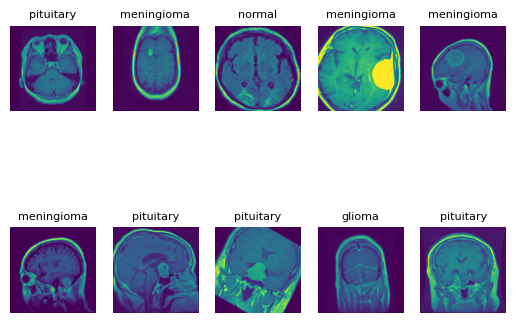

In [12]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2,5)

idx_to_class = {0: "normal", 1: "glioma", 2: "meningioma", 3: "pituitary"}
for i in range(5):
    ax[0, i].imshow(training_data[i+5][0].permute(1, 2, 0))
    ax[0, i].axis('off')
    ax[0, i].set_title(idx_to_class[training_data[i+5][1]], fontsize = 8)

for i in range(5):
    ax[1, i].imshow(testing_data[i+15][0].permute(1, 2, 0))
    ax[1, i].axis('off')
    ax[1, i].set_title(idx_to_class[testing_data[i+15][1]], fontsize = 8)

plt.show()

In [13]:
import torch.nn as nn
import torch.cuda as cuda
from torch.autograd import Variable
import torch.nn.functional as F

# Model

In [14]:
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Max pooling layers
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)

        # Output layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten the feature maps
        x = x.view(-1, 128 * 32 * 32)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [15]:
net = Net()

if cuda.is_available():
    net = net.cuda()
    
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)

# Training

In [ ]:
num_epoch = 50

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epoch):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    net.train()
    
    for i, (items, classes) in enumerate(train_dl):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
            
        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs.squeeze(0), classes)
        iter_loss += loss.data
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
        
    train_loss.append((iter_loss/iterations).cpu())
    train_accuracy.append((100 * correct / len(train_dl.dataset)).cpu())
    
    loss = 0
    correct = 0
    iterations = 0
    
    net.eval()
    
    for i, (items, classes) in enumerate(test_dl):
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).data # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    test_loss.append((loss/iterations).cpu())
    # Record the validation accuracy
    test_accuracy.append((correct / len(test_dl.dataset) * 100.0).cpu())

    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epoch, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

In [17]:
torch.save(net.state_dict(), "../../Vision/Brain_Tumor_MRI/result_model/3rd_model.pth")

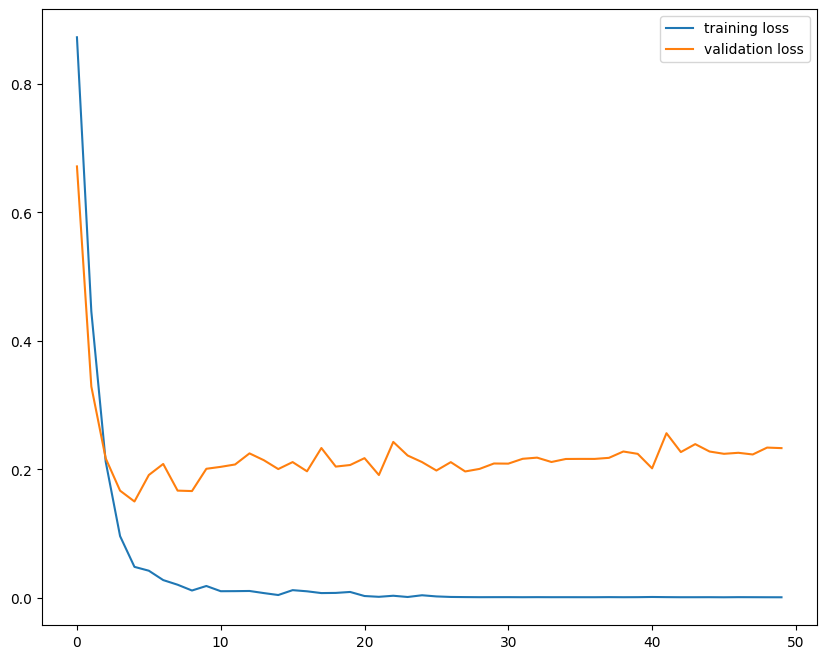

In [18]:
f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label='validation loss')
plt.legend()
plt.show()

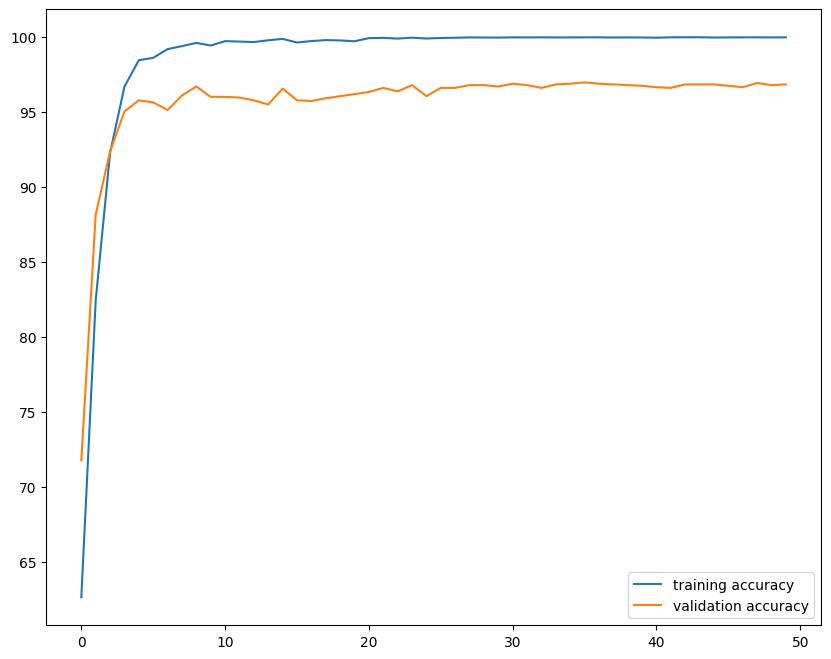

In [19]:
f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(test_accuracy, label='validation accuracy')
plt.legend()
plt.show()

In [21]:
from PIL import Image
from torchvision import transforms
import torch

def predict_image(image_path, model_path):
    model = Net()  
    model.load_state_dict(torch.load(model_path))
    model = model.cuda()
    model.eval()

    image = Image.open(image_path)
    image = T(image).unsqueeze(0) 
    image = image.cuda()

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        
    classes = ['Normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor' ]
    result = classes[predicted[0]]
    print(f"The image is classified as: {result}")

In [36]:
import os
import random

# 상위 디렉토리 경로
base_directory = '../../Data/Brain Tumors MRI Dataset/Tumor/'

# 하위 디렉토리 목록 가져오기
subdirectories = os.listdir(base_directory)

# 하위 디렉토리 중에서 랜덤하게 하나 선택
random_subdirectory = random.choice(subdirectories)

# 선택된 하위 디렉토리의 전체 경로
subdirectory_path = os.path.join(base_directory, random_subdirectory)

# 선택된 하위 디렉토리 안의 파일 목록 가져오기
files = os.listdir(subdirectory_path)

# 하위 디렉토리 안에서 랜덤하게 파일 선택
random_file = random.choice(files)

# 선택된 파일의 전체 경로 출력
random_file_path = os.path.join(subdirectory_path, random_file)
print("Randomly selected file:", random_file_path)


Randomly selected file: ../../Data/Brain Tumors MRI Dataset/Tumor/pituitary_tumor\P_811_SP_.jpg


In [37]:
best_model_path = "../Brain_Tumor_MRI/result_model/3rd_model.pth"
image_path = "../../Data/Brain Tumors MRI Dataset/Tumor/meningioma_tumor/M_103_BR_.jpg"

predict_image(random_file_path, best_model_path)

The image is classified as: pituitary_tumor
